In [1]:
import torch
from torch.nn import functional as F
from torchviz import make_dot, make_dot_from_trace


# setup

d = a + 2b

e = mse(d,a)

In [2]:
def initialize():
    a = torch.tensor([1., 2, 3, 4, 50], requires_grad=True)
    b = torch.tensor([2., 4, 6, 15, 200], requires_grad=True)
    c = torch.tensor([3.,5,7,9, 110], requires_grad=True)
    return a,b,c

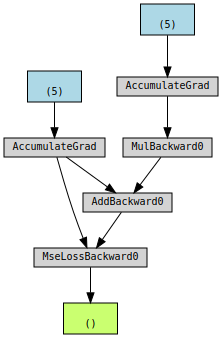

In [3]:
a,b,_ = initialize()
d = a + 2*b
d.retain_grad() # to access d.grad later on
e = F.mse_loss(d, a)
e.backward()
make_dot(e)

In [4]:
print(d.grad)
assert torch.equal(d.grad, 4*b/5)

tensor([  1.6000,   3.2000,   4.8000,  12.0000, 160.0000])


# copy grad from d to c

make `c` a leaf (`d` = `c` and `some_thing`...)

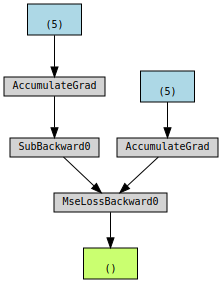

In [5]:
a,b,c = initialize()
d = a + 2*b
d = c - (c-d).detach() # copy grad from d to c, the other way around does NOT work: c = d - (d-c).detach() 
d.retain_grad() # to access d.grad later on
e = F.mse_loss(d, a)
e.backward()
make_dot(e)

In [6]:
d.grad

tensor([  1.6000,   3.2000,   4.8000,  12.0000, 160.0000])

In [7]:
c.grad

tensor([  1.6000,   3.2000,   4.8000,  12.0000, 160.0000])

In [8]:
assert torch.equal(d.grad, c.grad)

# stop grad

## WITHOUT stop grad (i.e., no `.detach()`)

d.grad:  tensor([  1.8000,   3.4000,   5.0000,  12.2000, 160.2000])


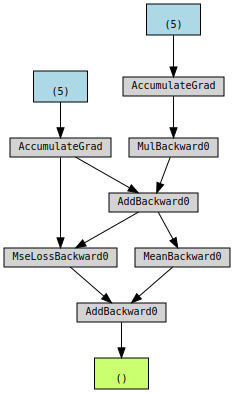

In [9]:
a,b,_ = initialize()
d = a + 2*b
d.retain_grad() # to access d.grad later on
e = F.mse_loss(d, a) + d.mean()
e.backward()

print("d.grad: ", d.grad)
make_dot(e)



## With stop grad (i.e., use `.detach()`)

d.grad:  tensor([  1.6000,   3.2000,   4.8000,  12.0000, 160.0000])


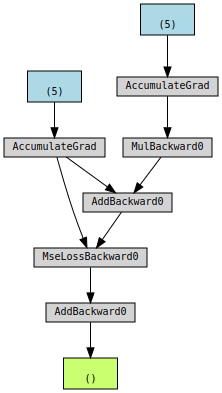

In [15]:
# a,b,_ = initialize()
d = a + 2*b
d.retain_grad() # to access d.grad later on
e = F.mse_loss(d, a) + d.mean().detach()
e.backward()

print("d.grad: ", d.grad)
make_dot(e)



In [16]:
d

tensor([  5.,  10.,  15.,  34., 450.], grad_fn=<AddBackward0>)

# torch Param vs. register buffer

In [76]:
class ToyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.my_param = torch.nn.Parameter(data=torch.Tensor([[10,12,13],[2,3,4]]))
        self.register_buffer("my_buffer", torch.Tensor([[10,12,13],[2,3,4]]))
        
    def run(self):
        self.my_buffer = self.my_buffer + 2* self.my_param
        return self.my_buffer



In [77]:
model = ToyModel()

In [78]:
model.my_param

Parameter containing:
tensor([[10., 12., 13.],
        [ 2.,  3.,  4.]], requires_grad=True)

In [79]:
model.my_param.data.requires_grad

False

In [80]:
model.my_param.requires_grad

True

In [81]:
model.my_buffer

tensor([[10., 12., 13.],
        [ 2.,  3.,  4.]])

In [82]:
model.my_buffer.requires_grad

False

In [83]:
model.run()
print("model.my_buffer.requires_grad", model.my_buffer.requires_grad)
model.my_buffer

model.my_buffer.requires_grad True


tensor([[30., 36., 39.],
        [ 6.,  9., 12.]], grad_fn=<AddBackward0>)